2024-07-27 11:36:21.761351 :: pyACC.CosmologicalDistances  ::    name    zcmb    zhel   dz         mb      dmb  x1  dx1  color  dcolor  \
0     0  0.0140  0.0140  0.0  14.570019  0.03110   0    0      0       0   
1     1  0.0194  0.0194  0.0  15.227960  0.02645   0    0      0       0   
2     2  0.0264  0.0264  0.0  15.934102  0.02310   0    0      0       0   
3     3  0.0329  0.0329  0.0  16.421783  0.02350   0    0      0       0   
4     4  0.0396  0.0396  0.0  16.836419  0.02845   0    0      0       0   

   3rdvar  d3rdvar  cov_m_s  cov_m_c  cov_s_c  set  ra  dec  
0       0        0        0        0        0    0   0    0  
1       0        0        0        0        0    0   0    0  
2       0        0        0        0        0    0   0    0  
3       0        0        0        0        0    0   0    0  
4       0        0        0        0        0    0   0    0  
2024-07-27 11:36:21.765774 :: pyACC.CosmologicalDistances  :: Covariance Matrix (Sigma):
2024-07-27 11:36:21.

  0%|          | 0/5000 [00:00<?, ?it/s]/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:13<00:00, 383.52it/s]


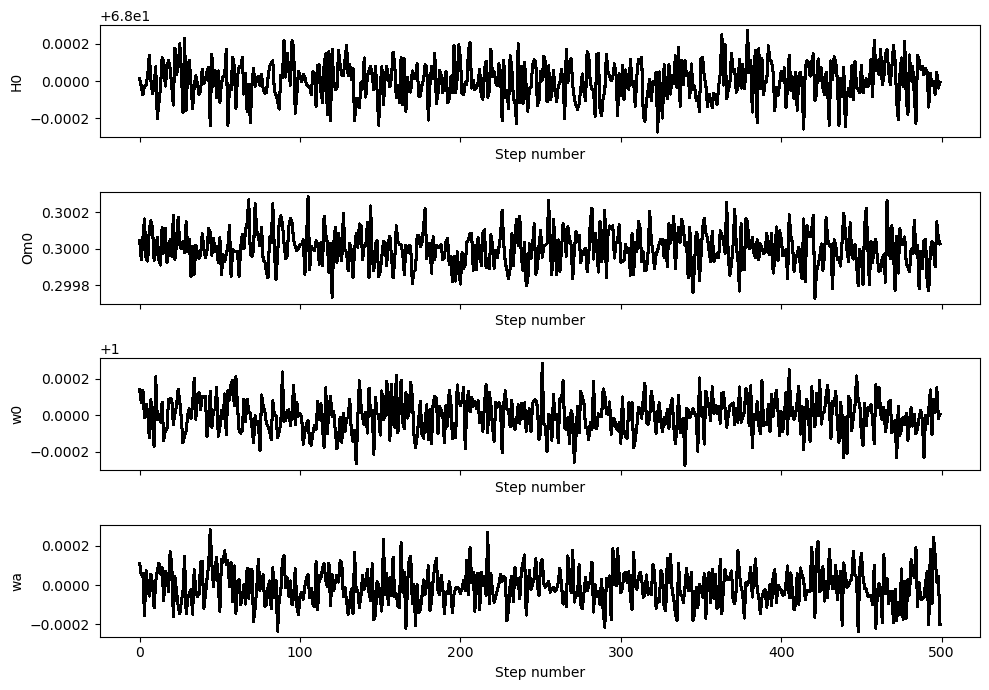

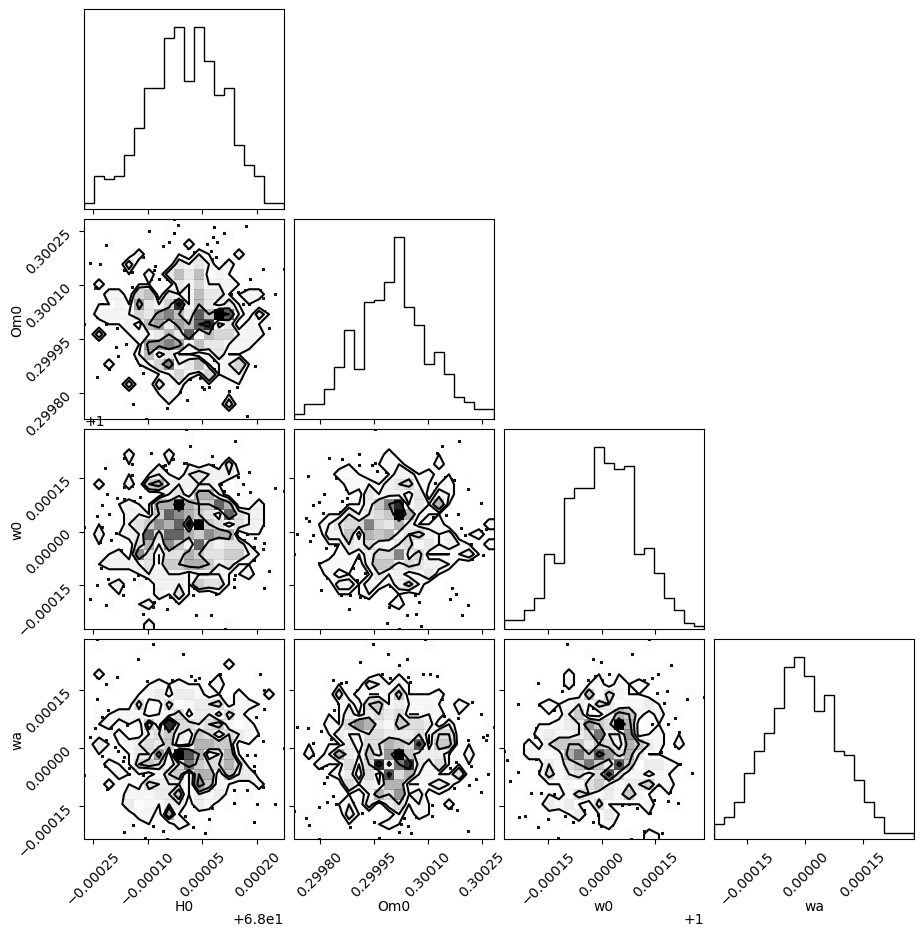

In [6]:
import sys
sys.path.append("../")
import platform
import os
import pandas as pd
import numpy as np
import math as m
import emcee
import corner
import matplotlib.pyplot as plt
import camb
# Import pyACC logger
from pyACC.helpers import Logger

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Import integration class
from pyACC.Cosmology.distances import Dc, Dc_w0wa, Dc_w

# Load the data
file_path = 'binned_data.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)

# Definition of the Hubble function and set the cosmology
def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz


def ln_likelihood(params, data, cov_inv):
    H0, Omega_matter, w0, wa = params
    z = data['zcmb'].values
    d = data['mb'].values + 19.3
    mu = []
    for z_prime in z:
        mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_matter, 0, 0, 0.7, w0, wa, H0)*(1+z_prime)) + 25)
    
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

def log_prior(params):
    H0, Om0, w0, wa = params
    if not (60 < H0 < 80):
        return -np.inf
    if not (0.2 < Om0 < 0.4):
        return -np.inf
    if not (-1. < w0 < -0.):
        return -np.inf
    if not (-2. < wa < -0.5):
        return -np.inf
    
    return 0.0

def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)

# Initialize the MCMC sampler
initial = np.array([68, 0.3, 1.0, 0]) # H0=68, Om0=0.3, w0=-0.3, wa=-1.3
ndim = len(initial)
nwalkers = 500
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim) # provare con 1e-1

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))

# Run the MCMC sampler
nsteps = 5000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=300, thin=10, flat=True)

# Plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["H0", "Om0", "w0", "wa"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i], color="k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlabel("Step number")

plt.tight_layout()
plt.show()

# Plot the results
fig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"])
plt.show()
